# Predicting Sequential Data With an RNN
In this notebook we'll introduce the concept of a [Recurrent Neural Network](https://youtu.be/AsNTP8Kwu80?si=SwLrsvavCfLhgv3V). By allowing the model to pass additional information to itself between time-steps it will be able to pass more information than just previous predictions.

[<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/2880px-Recurrent_neural_network_unfold.svg.png">](RNN)
<br>
[Corresponding Tutorial Video](https://youtu.be/YUGbMdfgpx0)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

from tqdm.notebook import trange, tqdm
from Dataset import WeatherDataset

In [2]:
# Path to the CSV file containing the weather dataset
dataset_file = "../data/weather.csv"

# Define the date to split the dataset into training and testing sets
split_date = pd.to_datetime('2023-01-01')

# Number of days in the input sequence
day_range = 15

# Number of days the MLP will take as input
days_in = 14

# Ensure that the total number of days in the input sequence is larger than the MLP input size
assert day_range > days_in, "The total day range must be larger than the input days for the MLP"

# Define the hyperparameters for training the model
learning_rate = 1e-4  # Learning rate for the optimizer
nepochs = 500  # Number of training epochs
batch_size = 32  # Batch size for training

# Create training dataset
# This will load the weather data, consider sequences of length day_range,
# and split the data such that data before split_date is used for training
dataset_train = WeatherDataset(dataset_file, day_range=day_range, split_date=split_date, train_test="train")

# Create testing dataset
# This will load the weather data, consider sequences of length day_range,
# and split the data such that data after split_date is used for testing
dataset_test = WeatherDataset(dataset_file, day_range=day_range, split_date=split_date, train_test="test")

In [3]:
print(f'Number of training examples: {len(dataset_train)}')
print(f'Number of testing examples: {len(dataset_test)}')

Number of training examples: 3480
Number of testing examples: 412


In [4]:
data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
data_loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, drop_last=True)

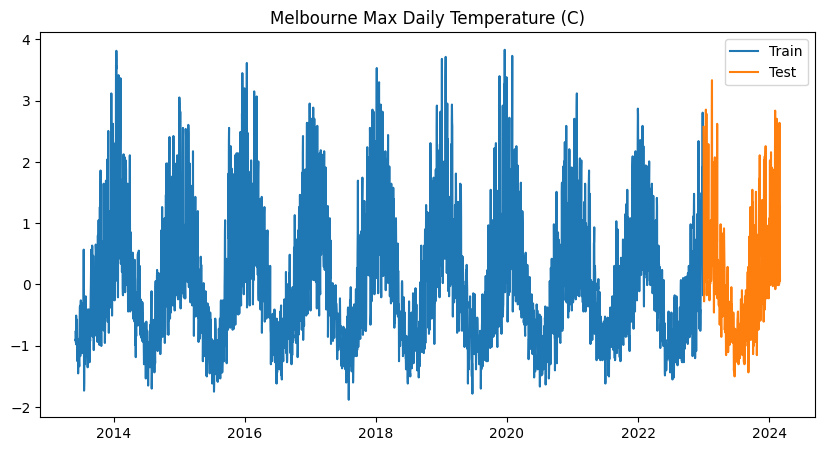

In [5]:
fig = plt.figure(figsize=(10, 5))
_ = plt.title("Melbourne Max Daily Temperature (C)")

_ = plt.plot(dataset_train.dataset.index, dataset_train.dataset.values[:, 1])
_ = plt.plot(dataset_test.dataset.index, dataset_test.dataset.values[:, 1])

_ = plt.legend(["Train", "Test"])
# Note:see here how we can just directly access the data from the dataset class

## Create RNN Network

In [6]:
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResBlockMLP, self).__init__()
        # Layer normalization for the input
        self.norm1 = nn.LayerNorm(input_size)
        # First fully connected layer that reduces the dimensionality by half
        self.fc1 = nn.Linear(input_size, input_size // 2)
        
        # Layer normalization after the first fully connected layer
        self.norm2 = nn.LayerNorm(input_size // 2)
        # Second fully connected layer that outputs the desired output size
        self.fc2 = nn.Linear(input_size // 2, output_size)
        
        # Skip connection layer to match the output size
        self.fc3 = nn.Linear(input_size, output_size)

        # Activation function
        self.act = nn.ELU()

    def forward(self, x):
        # Apply normalization and activation function to the input
        x = self.act(self.norm1(x))
        # Compute the skip connection output
        skip = self.fc3(x)
        
        # Apply the first fully connected layer, normalization, and activation function
        x = self.act(self.norm2(self.fc1(x)))
        # Apply the second fully connected layer
        x = self.fc2(x)
        
        # Add the skip connection to the output
        return x + skip


class RNN(nn.Module):
    def __init__(self, seq_len, output_size, num_blocks=1, buffer_size=128):
        super(RNN, self).__init__()
        
        # Compute the length of the sequence data
        seq_data_len = seq_len * 2

        # Define the input MLP with two fully connected layers and activation functions
        self.input_mlp = nn.Sequential(
            nn.Linear(seq_data_len, 4 * seq_data_len),
            nn.ELU(),
            nn.Linear(4 * seq_data_len, 128),
            nn.ELU()
        )

        # Define the RNN layer
        # Concatenates the input sequence with the buffer and feeds it through a linear layer
        self.rnn = nn.Linear(256, 128)
        
        # Define the sequence of residual blocks
        blocks = [ResBlockMLP(128, 128) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*blocks)
        
        # Final output fully connected layer
        self.fc_out = nn.Linear(128, output_size)
        
        # Fully connected layer for the buffer
        self.fc_buffer = nn.Linear(128, buffer_size)
        
        # Activation function
        self.act = nn.ELU()

    def forward(self, input_seq, buffer_in):
        # Reshape the input sequence to a flat vector
        input_seq = input_seq.reshape(input_seq.shape[0], -1)
        # Pass the input sequence through the input MLP
        input_vec = self.input_mlp(input_seq)
        
        # Concatenate the previous step buffer with the input vector
        x_cat = torch.cat((buffer_in, input_vec), 1)
        
        # Pass the concatenated vector through the RNN layer
        x = self.rnn(x_cat)

        # Pass the output through the sequence of residual blocks
        x = self.act(self.res_blocks(x))
        
        # Compute the final output and the updated buffer
        return self.fc_out(x), torch.tanh(self.fc_buffer(x))


In [7]:
# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# Define buffer size
buffer_size = 128

# Create RNN model and move it to the specified device
weather_rnn = RNN(seq_len=days_in, output_size=2, buffer_size=buffer_size).to(device)

# Initialize Adam optimizer with specified learning rate
optimizer = optim.Adam(weather_rnn.parameters(), lr=learning_rate)

# Define Mean Squared Error (MSE) loss function
loss_fn = nn.MSELoss()

# Initialize training loss logger
training_loss_logger = []

In [8]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in weather_rnn.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 100850 (Approximately 0 Million) Parameters!


## Training
This code is similar to the previous training loop, but instead of predicting future steps, it trains the model using the ground truth values only.

In [9]:
# Iterate over epochs
for epoch in trange(nepochs, desc="Epochs", leave=False):
    # Set the model to training mode
    weather_rnn.train()
    
    # Iterate over batches in training data
    for day, month, data_seq in tqdm(data_loader_train, desc="Training", leave=False):
        
        # Initialize the buffer with zeros
        buffer = torch.zeros(data_seq.shape[0], buffer_size, device=device)
        
        # Initialize loss
        loss = 0
        
        # Iterate over time steps
        for i in range(day_range - days_in):
            # Extract input sequence block and target sequence block
            seq_block = data_seq[:, i:(i + days_in)].to(device)
            target_seq_block = data_seq[:, i + days_in].to(device)
            
            # Feed buffer back into network in the next timestep
            data_pred, buffer = weather_rnn(seq_block, buffer)
            
            # Accumulate loss
            loss += loss_fn(data_pred, target_seq_block)
            
        # Calculate average loss
        loss /= i + 1
        
        # Backpropagation: Zero gradients, compute gradients, and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Log the training loss
        training_loss_logger.append(loss.item())

Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

Training:   0%|          | 0/108 [00:00<?, ?it/s]

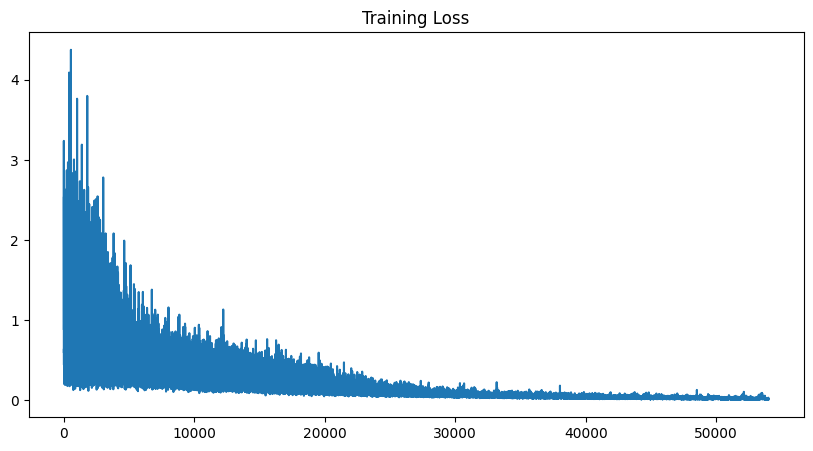

In [10]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger)
_ = plt.title("Training Loss")

## Testing
### Using Ground Truth First
This process involves predicting the first 30 time steps without using the model's predictions and then using the model's predictions for the subsequent time steps. This way the model gets more of the original first before predicting from its only predictions. 

In [11]:
# Convert test dataset values to a PyTorch tensor
data_tensor = torch.FloatTensor(dataset_test.dataset.values)

# Initialize an empty list to store predictions
log_predictions = []

# Set the model to evaluation mode
weather_rnn.eval()

# Initialize buffer with zeros
buffer = torch.zeros(1, buffer_size, device=device)

# Iterate over the first 30 time steps
for i in range(30):
    # Extract input sequence block for prediction
    seq_block = data_tensor[i:(i + days_in), :].unsqueeze(0).to(device)
    
    # Predict using the input sequence block and buffer
    data_pred, buffer = weather_rnn(seq_block, buffer)
    
    # Append prediction to the list
    log_predictions.append(data_pred.cpu())

# Continue predicting for the remaining time steps
for j in range(data_tensor.shape[0] - days_in - 30):
    # Update input sequence block by removing the oldest prediction and adding the new prediction
    seq_block = torch.cat((seq_block[:, 1:, :], data_pred.unsqueeze(1)), 1)
    
    # Predict using the updated input sequence block and buffer
    data_pred, buffer = weather_rnn(seq_block, buffer)
    
    # Append prediction to the list
    log_predictions.append(data_pred.cpu())

# Concatenate the logged predictions into a single tensor
predictions_cat = torch.cat(log_predictions)

# Unnormalize the predictions and original data using dataset's standard deviation and mean
un_norm_predictions = (predictions_cat * dataset_test.std) + dataset_test.mean
un_norm_data = (data_tensor * dataset_test.std) + dataset_test.mean
un_norm_data = un_norm_data[days_in:]

In [12]:
test_mse = (un_norm_data - un_norm_predictions).pow(2).mean().item()
print("Test MSE value %.2f" % test_mse)

Test MSE value 73.65


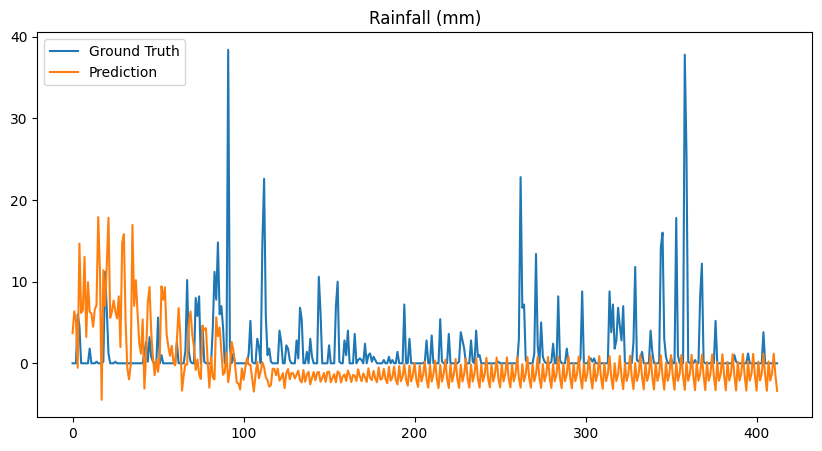

In [14]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(un_norm_data[:, 0])
_ = plt.plot(un_norm_predictions[:, 0].detach())
_ = plt.title("Rainfall (mm)")

_ = plt.legend(["Ground Truth", "Prediction"])

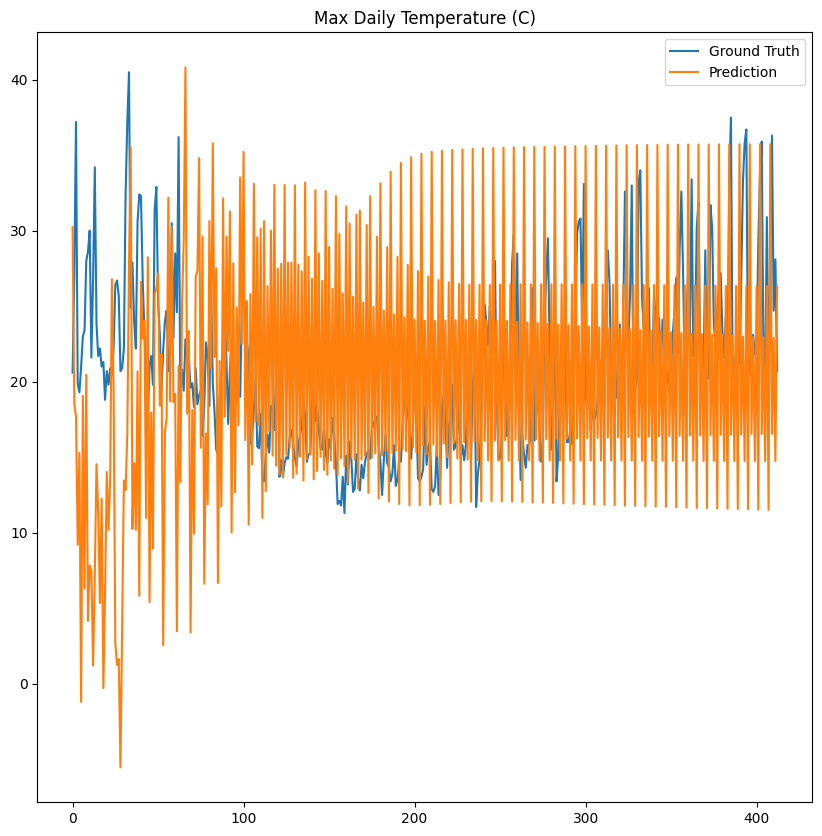

In [16]:
_ = plt.figure(figsize=(10, 10))
_ = plt.plot(un_norm_data[:, 1])
_ = plt.plot(un_norm_predictions[:, 1].detach())
_ = plt.title("Max Daily Temperature (C)")

_ = plt.legend(["Ground Truth", "Prediction"])